<a href="https://colab.research.google.com/github/ErycaFMS/introduction-to-data-science/blob/main/07_KNN_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**KNN e Avaliação de Algoritmos de Classificação Binária**

**Parte 1: Criando um conjunto de dados sintéticos com células preditoras bem desiguais**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

# Configurações para gráficos
plt.style.use('seaborn-darkgrid')
sns.set(style="whitegrid")

# Passo 1: Criar conjunto de dados sintéticos com mais complexidade
np.random.seed(42)
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3, n_redundant=2,
                           flip_y=0.2, class_sep=1.0, random_state=42)

# Introduzindo escalas desiguais
X[:, 0] *= 1000 # Multiplica a primeira coluna por 1000
X[:, 1] *= 100 # Multiplica a segunda coluna por 100
X[:, 2] *= 10 # Multiplica a terceira coluna por 10

# Transformar em DataFrame para melhor visualização
df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(X.shape[1])]) # Cria DataFrame com os dados
df['Target'] = y  # Adiciona a coluna de destino ao DataFrame

# Salvar os dados antes da padronização
df.to_csv('dados_antes_padronizacao.csv', index=False)


<ipython-input-1-3afa048f00a5>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


**Passo 2: Aplicando procedimento de padronização.** A padronização é essencial porque ajusta todas as variáveis para a mesma escala, garantindo que elas contribuam igualmente para cálculos de distância, como no kNN. Sem padronização, variáveis com magnitudes maiores dominam as distâncias, distorcendo os resultados do modelo. Ela melhora a performance, a estabilidade do treinamento e a interpretação dos coeficientes.

In [2]:
# Passo 2: Aplicar pad ronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Transformar os dados padronizados em DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=[f'Feature_{i}' for i in range(X.shape[1])])
df_scaled['Target'] = y

# Salvar os dados após a padronização
df_scaled.to_csv('dados_depois_padronizacao.csv', index=False)

**Passo 3 e 4: Dividindo o conjunto de dados em treino e teste, treinando e testando o algoritmo**

In [3]:
# Passo 3: Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Passo 4: Treinar o algoritmo kNN
k_values = range(1, 21) # Define os valores de k para testar
train_errors = [] # Lista para armazenar erros de treino sem padronização
test_errors = []  # Lista para armazenar erros de teste sem padronização

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k) # Cria o modelo kNN
    knn.fit(X_train, y_train)  # Treina o modelo com dados de treino
    train_errors.append(1 - knn.score(X_train, y_train)) # Calcula erro de treino e adiciona à lista
    test_errors.append(1 - knn.score(X_test, y_test)) # Calcula erro de teste e adiciona à lista

train_errors_scaled = [] # Lista para erros de treino com padronização
test_errors_scaled = [] # Lista para erros de teste com padronização

for k in k_values: # Para cada valor de k
    knn = KNeighborsClassifier(n_neighbors=k) # Cria o modelo kNN
    knn.fit(X_train_scaled, y_train) # Treina o modelo com dados padronizados
    train_errors_scaled.append(1 - knn.score(X_train_scaled, y_train))
    test_errors_scaled.append(1 - knn.score(X_test_scaled, y_test))


**Passo 5: Aplicando métricas de avaliação com e sem padronização**

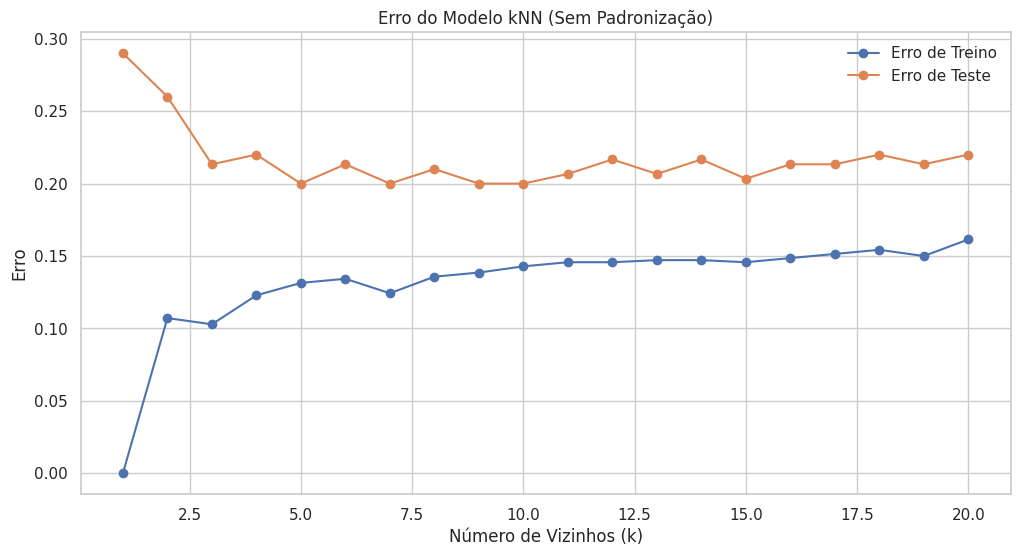

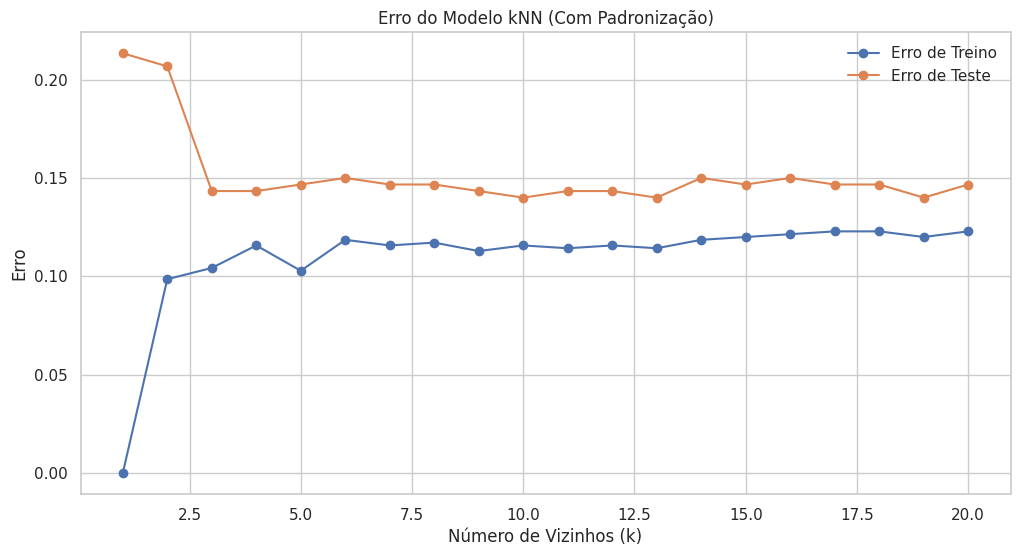

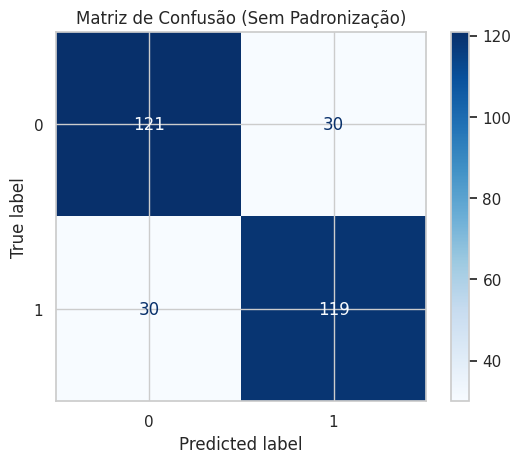

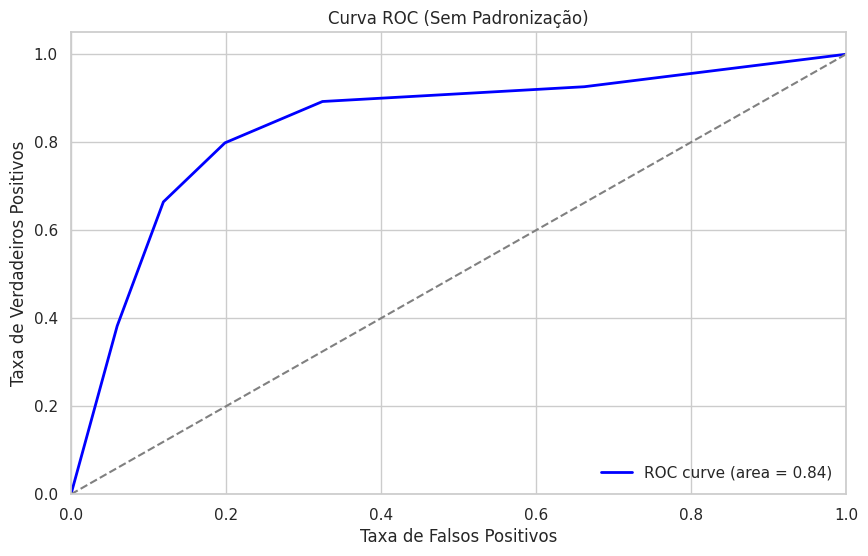

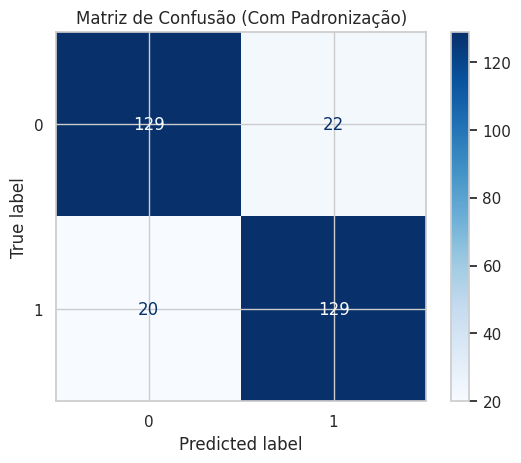

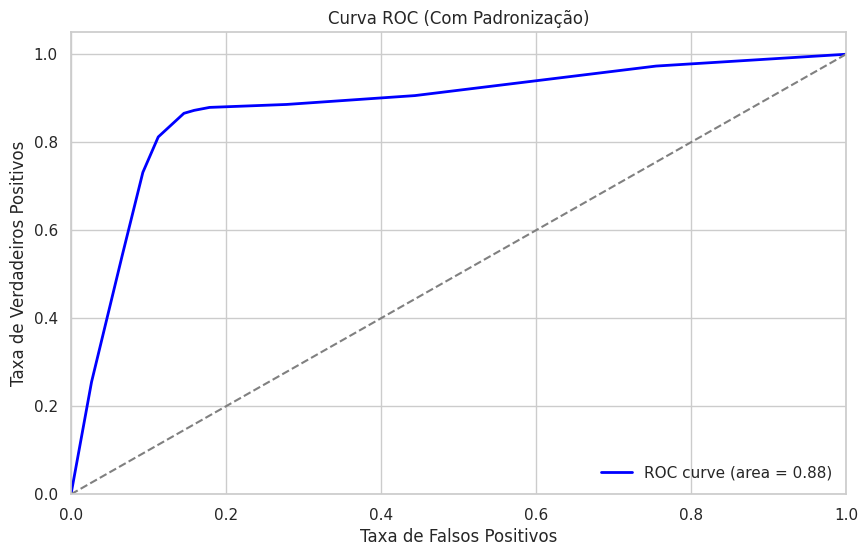

In [ ]:
# Passo 5: Avaliar o desempenho do modelo com e sem padronização
def plot_metrics(k_values, train_errors, test_errors, title):
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, train_errors, label='Erro de Treino', marker='o')
    plt.plot(k_values, test_errors, label='Erro de Teste', marker='o')
    plt.xlabel('Número de Vizinhos (k)')
    plt.ylabel('Erro')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(k_values, train_errors, test_errors, 'Erro do Modelo kNN (Sem Padronização)')
plot_metrics(k_values, train_errors_scaled, test_errors_scaled, 'Erro do Modelo kNN (Com Padronização)')

# Selecionar o melhor k baseado no menor erro de teste
best_k = k_values[np.argmin(test_errors)]
best_k_scaled = k_values[np.argmin(test_errors_scaled)]

# Treinar e avaliar com o melhor k (sem padronização)
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

# Treinar e avaliar com o melhor k (com padronização)
knn_best_scaled = KNeighborsClassifier(n_neighbors=best_k_scaled)
knn_best_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = knn_best_scaled.predict(X_test_scaled)

# Passo 6: Métricas de avaliação
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Métricas sem padronização
y_scores = knn_best.predict_proba(X_test)[:, 1]
plot_confusion_matrix(y_test, y_pred, 'Matriz de Confusão (Sem Padronização)')
plot_roc_curve(y_test, y_scores, 'Curva ROC (Sem Padronização)')

# Métricas com padronização
y_scores_scaled = knn_best_scaled.predict_proba(X_test_scaled)[:, 1]
plot_confusion_matrix(y_test, y_pred_scaled, 'Matriz de Confusão (Com Padronização)')
plot_roc_curve(y_test, y_scores_scaled, 'Curva ROC (Com Padronização)')

# Fronteira de decisão
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1)) # Cria grade de pontos
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # Faz previsões para todos os pontos da grade
    Z = Z.reshape(xx.shape) # Ajusta o formato das previsões para o gráfico

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o', cmap=plt.cm.Paired)
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)
    plt.show()

# Nota: Para simplificar, consideramos apenas duas características
X_train_2d, X_test_2d = X_train[:, :2], X_test[:, :2]
X_train_scaled_2d, X_test_scaled_2d = X_train_scaled[:, :2], X_test_scaled[:, :2]

# Plotar fronteira de decisão sem padronização
knn_best.fit(X_train_2d, y_train)
plot_decision_boundary(X_test_2d, y_test, knn_best, 'Fronteira de Decisão (Sem Padronização)')

# Plotar fronteira de decisão com padronização
knn_best_scaled.fit(X_train_scaled_2d, y_train)
plot_decision_boundary(X_test_scaled_2d, y_test, knn_best_scaled, 'Fronteira de Decisão (Com Padronização)')

**Passo 6: Conclusão**

A padronização dos dados é essencial quando as variáveis preditoras possuem escalas muito diferentes, pois o kNN calcula distâncias entre pontos. Se as escalas forem desiguais, as variáveis com maior magnitude dominarão a medida de distância, o que pode afetar negativamente a performance do modelo.
Observamos que, após a padronização, o desempenho do kNN geralmente melhora. Isso é evidenciado pela análise dos erros de treino e teste, das matrizes de confusão e das curvas ROC. A padronização permite que o modelo trate todas as variáveis com igual importância e melhora a precisão da classificação.
As fronteiras de decisão também mostram mudanças significativas após a padronização, refletindo a importância da padronização para obter resultados mais equilibrados e precisos.